In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeRegressor

import optuna

import lightgbm as lgb

In [76]:
df = pd.DataFrame()

l = ["data-2016.csv","data-2017.csv","data-2018.csv","data-2019.csv","data-2020.csv","data-2021.csv"]
for data in l:
    df_csv = pd.read_csv(f"data/{data}")
    df = pd.concat([df, df_csv])
df.index = np.arange(len(df))
df.drop_duplicates(subset=["id", "num"], inplace=True)

df["min_age"] = df.groupby("id")["age_x"].transform(min)

df = df[df["min_age"] > 3]

df["classement"] = df["classement"].replace(['DA', 'D4', 'A ',
       'D ', 'G ', 'G0', 'D3', 'H9', 'D9', 'D1', 'D5', 'D8', 'H8', 'G3',
       'D2', 'G2', 'G1', 'T ', 'G5', 'D7', 'D6', 'G4', 'G7', '10',
       'R8', 'G6'], 'D').fillna('D').replace(['0', '6', '7', '8', '9'], 'NC')

# df["nbCourseCouple"] = df["nbCourseCouple"] + 1
# df.loc[df["dernierRapportDirect_rapport"] <= 2, "nbVictoiresCouple"] = df["nbVictoiresCouple"] + 1
# df.loc[df["dernierRapportDirect_rapport"] <= 10, "nb2emeCouple"] = df["nb2emeCouple"] + 1
# df.loc[df["dernierRapportDirect_rapport"] <= 20, "nb3emeCouple"] = df["nb3emeCouple"] + 1
# df["txReussiteCouple"] =(( df["nb3emeCouple"] + df["nb2emeCouple"] + df["nbVictoiresCouple"]) / df["nbCourseCouple"]) * 100

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (123) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (119,120,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (119) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (42,43,53,54,57,119) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_as

In [77]:
df = df.groupby("id").filter(lambda x: len(x) > 7)

In [78]:
df = df[['num',
 'nom',
 'numCoursePMU',
 'classement',
 'id',
 'date',
 'meanReduction',
 'medianReduction',
 'maxReduction',
 'minReduction',
 'timeSinceRecord',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'music',
 'nbDiscalifieMusic',
 'nbVictoireMusic',
 'nbPlaceMusic',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'sexe',
 'race',
 'musique',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'nomPere',
 'nomMere',
 'jumentPleine',
 'engagement',
 'supplement',
 'tempsObtenu',
 'reductionKilometrique',
         'entraineur',
         'driver_y',
 'urlCasaque',
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_rapport',
 'dernierRapportDirect_favoris',
 'dernierRapportReference_rapport',
 'dernierRapportReference_favoris',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple',
 'nonPartant',
 'nbCourseTrainer',
 'nbVictoiresTrainer',
 'nb2emeTrainer',
 'nb3emeTrainer',
 'txReussiteTrainer',
 'nbCourseTandem',
 'nbVictoiresTandem',
 'nb2emeTandem',
 'nb3emeTandem',
 'txReussiteTandem',
 'nbCourseDriver',
 'nbVictoiresDriver',
 'nb2emeDriver',
 'nb3emeDriver',
 'txReussiteDriver']]

In [79]:
df

,num,nom,numCoursePMU,classement,id,date,meanReduction,medianReduction,maxReduction,minReduction,...,nbCourseTandem,nbVictoiresTandem,nb2emeTandem,nb3emeTandem,txReussiteTandem,nbCourseDriver,nbVictoiresDriver,nb2emeDriver,nb3emeDriver,txReussiteDriver
0,1,UNO DU MESNIL,R1C4,NC,2016010175004,2016-01-01,784.297297,780.0,876,753,...,12,1,0,1,16,1 428,179,136,139,31
1,2,VIVIEN PEO,R1C4,4,2016010175004,2016-01-01,768.307692,767.0,803,721,...,175,24,27,18,39,218,25,30,21,34
2,3,VIVAT DE VOUEDE,R1C4,D,2016010175004,2016-01-01,769.434783,763.0,827,745,...,129,18,11,16,34,133,18,11,17,34
3,4,VERNOUILLET,R1C4,D,2016010175004,2016-01-01,767.593750,765.0,818,728,...,3,0,0,1,33,1 650,220,175,170,34
4,5,UNITED POINIERE,R1C4,D,2016010175004,2016-01-01,774.235294,773.5,821,737,...,1,0,0,0,0,144,14,12,20,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130446,12,HARLEY GEMA,R1C9,3,2021123175009,2021-12-31,778.500000,782.0,796,753,...,2,0,0,1,50,1 034,104,97,92,28
130447,13,HAUTE COUTURE,R1C9,NC,2021123175009,2021-12-31,766.272727,762.0,787,751,...,160,32,25,21,48,203,33,25,26,41
130448,14,HORCHATA,R1C9,NC,2021123175009,2021-12-31,766.727273,765.0,807,733,...,3,1,0,1,66,893,98,82,85,29
130449,15,HELIA DU GARABIN,R1C9,NC,2021123175009,2021-12-31,769.500000,766.5,805,741,...,119,15,10,10,29,171,21,13,12,26


In [81]:
df["bestTimeInRace"] = df.groupby("id")["recordAbs"].transform(min)
df["bestMeanTimeInRace"] = df.groupby("id")["meanReduction"].transform(min)
df["timeBehindBestInRace"] = df["recordAbs"] - df["bestTimeInRace"]
df["timeBehindBestMeanInRace"] = df["meanReduction"] - df["bestMeanTimeInRace"]

df["trainerIsDriver"] = df["entraineur"] == df["driver_y"]

In [82]:
groups = df[['id',
            'meanPerf',
            'medianPerf',
            'modePerf',
            'recordAbs',
            'nbDiscalifieMusic',
            'nbVictoireMusic',
            'nbPlaceMusic',
            'nbArrivé',
            'nombreCourses',
            'nombreVictoires',
            'nombrePlaces',
            'nombrePlacesSecond',
            'nombrePlacesTroisieme',
            'gainsParticipant_gainsCarriere',
            'gainsParticipant_gainsVictoires',
            'gainsParticipant_gainsPlace',
            'gainsParticipant_gainsAnneeEnCours',
            'gainsParticipant_gainsAnneePrecedente',
            'nbCourseCouple',
            'nbVictoiresCouple',
            'nb2emeCouple',
            'nb3emeCouple',
            'txReussiteCouple',
            'nbCourseTrainer',
            'timeBehindBestInRace',
            'timeBehindBestMeanInRace',
            'dernierRapportDirect_rapport',
            'dernierRapportReference_rapport',
            'meanReduction',
            'medianReduction',
            'maxReduction',
            'minReduction',
            'timeSinceRecord',
            'nbVictoiresTrainer',
            'nb2emeTrainer',
            'nb3emeTrainer',
            'txReussiteTrainer',
            'nbCourseTandem',
            'nbVictoiresTandem',
            'nb2emeTandem',
            'nb3emeTandem',
            'txReussiteTandem',
            'nbCourseDriver',
            'nbVictoiresDriver',
            'nb2emeDriver',
            'nb3emeDriver',
            'txReussiteDriver']].groupby("id")
mean, std = groups.transform("mean"), groups.transform("std")
normalized = (df[mean.columns] - mean) / std

In [83]:
df = df.join(normalized, lsuffix='', rsuffix='_z')

In [90]:
df["reductionKilometrique"]

0         76500.0
1         76200.0
2             NaN
3             NaN
4             NaN
           ...   
130446    75000.0
130447    75100.0
130448    75100.0
130449    75200.0
130450    75000.0
Name: reductionKilometrique, Length: 124021, dtype: float64

In [3]:
df.dropna(inplace=True)

In [2]:
df = pd.read_csv("data/data_normalized.csv", index_col=0)
df.head()

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,num,nom,numCoursePMU,classement,id,date,meanReduction,medianReduction,maxReduction,minReduction,...,txReussiteTrainer_z,nbCourseTandem_z,nbVictoiresTandem_z,nb2emeTandem_z,nb3emeTandem_z,txReussiteTandem_z,nbVictoiresDriver_z,nb2emeDriver_z,nb3emeDriver_z,txReussiteDriver_z
0,1,UNO DU MESNIL,R1C4,NC,2016010175004,2016-01-01,784.297297,780.0,876,753,...,-1.668194,-0.738903,-0.894947,-0.792787,-0.741477,-1.102612,1.588863,1.672821,1.886377,0.337946
1,2,VIVIEN PEO,R1C4,4,2016010175004,2016-01-01,768.307692,767.0,803,721,...,0.600550,0.507040,0.930216,1.335911,0.570037,0.569481,-0.556450,-0.424250,-0.638301,0.831165
2,3,VIVAT DE VOUEDE,R1C4,D,2016010175004,2016-01-01,769.434783,763.0,827,745,...,0.734005,0.155424,0.454086,0.074461,0.415742,0.205983,-0.653965,-0.800140,-0.723884,0.831165
3,4,VERNOUILLET,R1C4,D,2016010175004,2016-01-01,767.593750,765.0,818,728,...,-0.333639,-0.807698,-0.974302,-0.792787,-0.741477,0.133283,2.160018,2.444385,2.549639,0.831165
4,5,UNITED POINIERE,R1C4,D,2016010175004,2016-01-01,774.235294,773.5,821,737,...,-1.401283,-0.822985,-0.974302,-0.792787,-0.818625,-2.265808,-0.709687,-0.780357,-0.659697,0.337946


In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:5000][features], df.iloc[:5000]["classement"], test_size=0.33, random_state=42)

In [8]:
clf = make_pipeline(StandardScaler(), LinearSVC())
clf.fit(X_train, y_train)

C:\Users\raves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])

In [52]:
clf2 = MLPClassifier(random_state=1, max_iter=3000, activation="logistic").fit(X_train, y_train)

In [53]:
df2 = df.loc[:].iloc[5000:7000]
df2["pred"] = clf2.predict(df2[features])

In [55]:
df2["pred"].unique()

array(['NC', '1', '4'], dtype=object)

In [11]:
clf.predict(X_test)

array(['1', '2', '3', '4', '5', 'D', 'NC'], dtype=object)

In [31]:
predictions = pd.Series(clf.predict(X_test))
real = pd.DataFrame([predictions, y_test])

In [35]:
y_test.to_numpy()

array(['5', 'NC', '2', ..., 'NC', '3', '2'], dtype=object)

In [19]:
df["classement"].iloc[-1]

'4'

In [6]:
features = ['num',
            'tpsLastRace',
            'last_race_dist',
            'fer',
            'firstTimeFer',
            'sex',
            'age_x',
            'dist',
            'avisTrainer',
'lastPerf',
 'meanPerf_z',
 'medianPerf_z',
 'modePerf_z',
 'recordAbs_z',
 'nbDiscalifieMusic_z',
 'nbVictoireMusic_z',
 'nbPlaceMusic_z',
 'nbArrivé_z',
 'nombreCourses_z',
 'nombreVictoires_z',
 'nombrePlaces_z',
 'nombrePlacesSecond_z',
 'nombrePlacesTroisieme_z',
 'gainsParticipant_gainsPlace_z',
 'gainsParticipant_gainsAnneeEnCours_z',
 'gainsParticipant_gainsAnneePrecedente_z',
 'nbCourseCouple_z',
 'nbVictoiresCouple_z',
 'nb2emeCouple_z',
 'nb3emeCouple_z',
 'txReussiteCouple_z',
 'timeBehindBestInRace_z',
 'timeBehindBestMeanInRace_z',
 'meanReduction_z',
 'medianReduction_z',
 'maxReduction_z',
 'minReduction_z',
 'timeSinceRecord_z',
 'nbVictoiresTrainer_z',
 'nb2emeTrainer_z',
 'nb3emeTrainer_z',
 'txReussiteTrainer_z',
 'nbCourseTandem_z',
 'nbVictoiresTandem_z',
 'nb2emeTandem_z',
 'nb3emeTandem_z',
 'txReussiteTandem_z',
 'nbVictoiresDriver_z',
 'nb2emeDriver_z',
 'nb3emeDriver_z',
 'txReussiteDriver_z',
             'trainerIsDriver']

In [54]:
df_train = df.loc[:][features].apply(pd.to_numeric, errors="coerce")
y = df["classement"].replace(['DA', 'D1', 'A ',
       'D7', 'D8', 'H8', 'T ', 'G ', 'D5', 'D6', 'D', 'D3', 'D4', 'D2', 'D ',
       'G5', 'D9', 'H9', 'G4', 'R8', 'G6'], 10)

y = pd.to_numeric(y,downcast="integer",errors='coerce').fillna(10).replace(0,10).astype(np.int32)

ids = df.loc[:]["id"]
# df_train["dernierRapportReference_indicateurTendance"] = df_train["dernierRapportReference_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0)


In [55]:
gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7)

gss2 = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(df_train, y, groups=ids)

X_train_inds, X_test_inds = next(gss2)

train_data= df_train.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['id'])]
y_train = y.iloc[X_train_inds]

groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

test_data = df_train.loc[:].iloc[X_test_inds]

#We need to keep the id for later predictions
X_test = test_data.loc[:, ~test_data.columns.isin(['id'])]
y_test = y.iloc[X_test_inds]

test_groups = test_data.groupby('id').size().to_frame('size')['size'].to_numpy()

In [714]:
gss.get_n_splits()

1

In [77]:
df_train

,num,id,tpsLastRace,last_race_dist,fer,firstTimeFer,sex,age_x,dist,avisTrainer,...,nbCourseTandem_z,nbVictoiresTandem_z,nb2emeTandem_z,nb3emeTandem_z,txReussiteTandem_z,nbVictoiresDriver_z,nb2emeDriver_z,nb3emeDriver_z,txReussiteDriver_z,trainerIsDriver
0,1,2016010175004,9,2850,3,False,1,8,2850,2,...,-0.738903,-0.894947,-0.792787,-0.741477,-1.102612,1.588863,1.672821,1.886377,0.337946,False
1,2,2016010175004,9,2850,3,False,1,7,2850,2,...,0.507040,0.930216,1.335911,0.570037,0.569481,-0.556450,-0.424250,-0.638301,0.831165,True
2,3,2016010175004,12,2900,0,False,0,7,2850,2,...,0.155424,0.454086,0.074461,0.415742,0.205983,-0.653965,-0.800140,-0.723884,0.831165,True
3,4,2016010175004,12,2900,3,False,1,7,2850,2,...,-0.807698,-0.974302,-0.792787,-0.741477,0.133283,2.160018,2.444385,2.549639,0.831165,False
4,5,2016010175004,5,2100,3,False,1,8,2850,2,...,-0.822985,-0.974302,-0.792787,-0.818625,-2.265808,-0.709687,-0.780357,-0.659697,0.337946,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49358,12,2021061613036,45,3525,0,False,1,9,3025,3,...,-0.845720,-0.820518,-0.773007,-0.853577,-1.429294,-0.689438,-0.830814,-0.956658,1.399908,False
49359,13,2021061613036,18,2875,1,False,1,9,3025,2,...,-0.172828,-0.457105,-0.555258,-0.091586,-0.187224,-0.790331,-0.864046,-0.589595,-0.717366,True
49360,14,2021061613036,9,3550,6,True,0,7,3025,2,...,0.337981,0.860266,0.097987,0.025644,0.616469,0.218602,-0.365558,-0.552889,0.619860,True
49361,15,2021061613036,12,3025,0,False,1,10,3025,2,...,1.089459,1.723371,1.448026,1.197939,1.127910,1.395691,1.163140,0.548301,1.288472,True


In [715]:
for train_idx, test_idx in gss.split(df_train,y, groups=ids):
    print("TRAIN:", train_idx, "TEST:", test_idx)

TRAIN: [   0    1    2 ... 6185 6186 6187] TEST: [  30   31   32 ... 6198 6199 6200]


# Hyperparameter

In [873]:
from optuna.integration import LightGBMPruningCallback
from scipy import stats
import sklearn.metrics

def objective(trial):
    param_grid = {
    "n_estimators": trial.suggest_int("n_estimators", 100,5000),
    "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
    "num_leaves": trial.suggest_int("num_leaves", 20, 3000),
    "max_depth": trial.suggest_int("max_depth", -1, 500),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000),
    }
    model = lgb.LGBMRanker(n_jobs=24,objective="lambdarank",boosting_type = "dart",metric= "ndcg", **param_grid)
    
    scores = []
    
    for X_train_inds, X_test_inds in gss.split(df_train,y, groups=ids):
        train_data = df_train.iloc[X_train_inds]
        X_train = train_data.loc[:, ~train_data.columns.isin(['id'])]
        y_train = y.iloc[X_train_inds]
        groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()
        
        test_data = df_train.iloc[X_test_inds]
        X_test = test_data.loc[:, ~test_data.columns.isin(['id'])]
        y_test = y.iloc[X_test_inds]
        test_groups = test_data.groupby('id').size().to_frame('size')['size'].to_numpy()
        
        model.fit(
            X_train,
            y_train,
            group = groups,
        )
        
        preds = model.predict(X_test)
        test_data["rank_pred"] = preds
        test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
        test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("first").astype(int)

        test_data["classement"] = y_test
        corr_coef = test_data[["classement", "rank_pred"]].corr(method="spearman")["classement"].loc["rank_pred"]
        preds_percentage = len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1]) / len(test_data.groupby("id"))
        return preds_percentage
        scores.append(preds_percentage)
        
    return np.mean(scores)

In [874]:
study = optuna.create_study(direction="maximize", study_name="LGBM Ranker")
func = lambda trial: objective(trial)
study.optimize(func, n_trials=100)

[I 2022-11-16 20:02:23,923] A new study created in memory with name: LGBM Ranker


[LightGBM] [Warning] min_data_in_leaf is set=8136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8136


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=866, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=866


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=1330, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1330


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=6724, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6724


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=6561, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6561


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=9715, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9715


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=3046, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3046


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=7355, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7355


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=3223, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3223


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=8978, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8978


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=752, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=752


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=372, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=372


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=418, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=418


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=2849, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2849


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=4820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4820


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=2427, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2427


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=4899, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4899


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=2005, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2005


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=3963, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3963


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=1355, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1355


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=304, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=304


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=1822, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1822


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=880


<ipython-input-873-3f6f37d4b362>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["rank_pred"] = preds
<ipython-input-873-3f6f37d4b362>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
<ipython-input-873-3f6f37d4b362>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[LightGBM] [Warning] min_data_in_leaf is set=4026, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4026


[W 2022-11-16 20:18:40,188] Trial 24 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\raves\AppData\Roaming\Python\Python38\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-874-86106061c4e1>", line 2, in <lambda>
    func = lambda trial: objective(trial)
  File "<ipython-input-873-3f6f37d4b362>", line 28, in objective
    model.fit(
  File "C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 1067, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score, group=group,
  File "C:\Users\raves\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\raves\anaconda3\lib\site-packages\lightgbm\engine.py", line 292, in train
    booster.update(fobj=fobj)
  File "C:\Users\raves\anaconda3\lib\site-packages\lightgbm\basic.py", line 3021, in update
    _safe_call(_LIB.L

KeyboardInterrupt: 

In [739]:
print('Number of finished trials:', len(study.trials))
print('Best Correlation', study.best_value)
print('Best trial:', study.best_trial.params)

Number of finished trials: 100
Best Correlation 0.24352331606217617
Best trial: {'n_estimators': 1334, 'learning_rate': 0.0010018195175954846, 'num_leaves': 1111, 'max_depth': 219, 'min_data_in_leaf': 489}


In [740]:
params2 = {'n_estimators': 1894, 'learning_rate': 0.015482062204812644, 'num_leaves': 2839, 'max_depth': 403, 'min_data_in_leaf': 2844}
params = {'n_estimators': 300, 'learning_rate': 0.03044996692992604, 'num_leaves': 2960, 'max_depth': 349, 'min_data_in_leaf': 200}

In [741]:
len(list(test_data))

58

In [71]:
gbm = lgb.LGBMRanker(objective="lambdarank",
                    boosting_type = "gbdt",
                    importance_type = "split",
                    n_jobs=24,
                    metric= "ndcg")

In [72]:
gbm.fit(X_train, y_train, group=groups)

LGBMRanker(metric='ndcg', n_jobs=24, objective='lambdarank')

In [73]:
len(list(X_train))

52

In [80]:
df[["tpsLastRace", "classement"]].corr()

,tpsLastRace,classement
tpsLastRace,1.000000,-0.031445
classement,-0.031445,1.000000


In [74]:
predictions = gbm.predict(X_test)
test_data["rank_pred"] = predictions
test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("dense",ascending=True).astype(int)
test_data['rank_pred'] = test_data.groupby("id")["rank_pred"].rank("first").astype(int)

test_data["classement"] = y_test

In [75]:
test_data[["classement", "rank_pred"]].corr(method="spearman")["classement"].loc["rank_pred"]

0.36155662788638676

In [76]:
len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1]) / len(test_data.groupby("id"))

0.17002881844380405

In [68]:
print(len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1]), len(test_data.groupby("id")))

235 1388


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

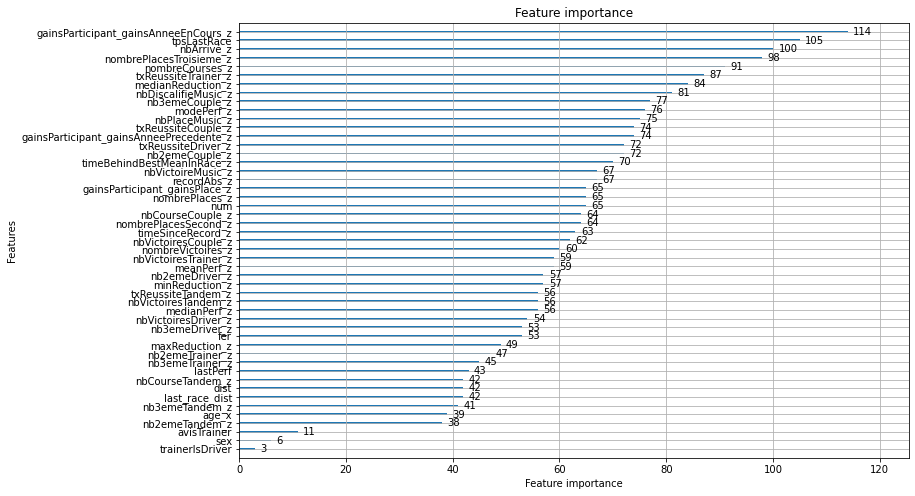

In [78]:
lgb.plot_importance(gbm, figsize = (12,8))

In [472]:
gbm.booster_.save_model("models/modelv4.txt")

In [65]:
def get_proba(rapport_min):
    n = len(test_data.loc[test_data["dernierRapportReference_rapport"] > rapport_min].loc[test_data["rank_pred"] == 1])
    p = len(test_data.loc[test_data["dernierRapportReference_rapport"] >= rapport_min].loc[test_data["rank_pred"] == 1].loc[test_data["classement"]==1]) / n
    return p, n

In [66]:
get_proba(20)

(0.3, 400)

In [45]:
np.mean([0.3,1/20])

0.175

In [106]:
class_rapport = np.arange(5,50,5)
nb_victoire = []
for i in class_rapport:
    nb_victoire.append( len(test_data.loc[test_data["rank_pred"] == 1].loc[test_data["classement"] == 1].loc[test_data["dernierRapportDirect_rapport"] < i ]) - sum(nb_victoire))

KeyError: 'dernierRapportDirect_rapport'

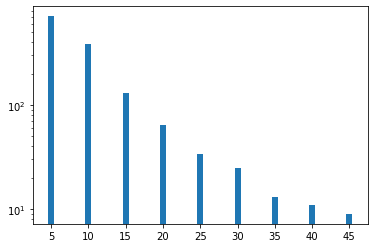

In [56]:
plt.bar(class_rapport,nb_victoire)
plt.yscale("log")

175 638 -98.59999999999998


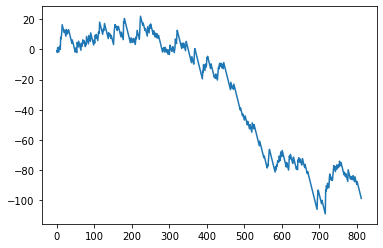

In [767]:
wins = 0
loses = 0

argent = 0

evo = []

test_data["rapport"] = df.loc[:]["dernierRapportDirect_rapport"].iloc[X_test_inds]
for i, row in test_data.loc[test_data["rank_pred"] == 1].iterrows():
    if not np.isnan(row["rapport"]) and row["rapport"] > 2:
        if row["classement"] == 1:
            wins += 1
            argent += row["rapport"] - 1
        else:
            loses += 1
            argent -= 1
        evo.append(argent)
print(wins, loses, argent)
plt.plot(evo)

In [693]:
G = test_data.groupby("id").apply(lambda g: g[(g["rank_pred"]) <= 3].loc[g["rank_pred"] == g["classement"]])

In [694]:
G.index = np.arange(len(G))
G

,num,id,tpsLastRace,last_race_dist,fer,firstTimeFer,sex,age_x,dist,avisTrainer,...,nb2emeTandem,nb3emeTandem,txReussiteTandem,nbCourseDriver,nbVictoiresDriver,nb2emeDriver,nb3emeDriver,txReussiteDriver,rank_pred,classement
0,1,2016010575007,16,2100,2,True,1,4,2100,2,...,63,49,51,NaN,226,140,96,43,3,3
1,8,2016010975004,9,2700,1,False,1,8,2100,2,...,8,7,47,904.0,106,102,88,32,2,2
2,15,2016011075002,14,1800,3,False,1,5,2175,2,...,1,0,33,701.0,126,80,60,37,1,1
3,2,2016011444134,4,2825,3,False,1,5,3000,2,...,32,23,33,324.0,48,33,24,32,2,2
4,14,2016012175001,18,2100,3,True,0,5,2700,2,...,3,13,50,NaN,233,210,157,36,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,3,2021012575006,40,2100,3,True,1,4,2100,2,...,48,30,62,411.0,121,56,45,54,2,2
67,8,2021013075005,27,2700,3,False,1,5,2850,2,...,5,13,26,766.0,50,54,87,24,3,3
68,4,2021013075009,21,2925,2,False,0,7,2100,1,...,18,13,80,60.0,17,18,13,80,1,1
69,13,2021013144135,19,2650,3,False,1,7,3025,1,...,7,1,38,839.0,82,88,62,27,2,2


In [695]:
len(G.groupby("id").filter(lambda x: len(x) == 3))/3 / len(test_data.groupby("id"))

0.005494505494505495

In [697]:
len(G.groupby("id").filter(lambda x: len(x) == 3))/3

1.0

In [87]:
G.groupby("id").filter(lambda x: len(x) == 2)[["id", "num", "rank_pred", "classement"]]

,id,num,rank_pred,classement
0,2015010844132,4,1,1
1,2015010844132,5,2,2
7,2015012561029,4,1,1
8,2015012561029,16,2,2
9,2015020175008,5,2,2
...,...,...,...,...
2963,2021123175006,9,1,1
2964,20170402510210,1,2,2
2965,20170402510210,12,1,1
2967,20190224750010,7,1,1


In [5]:
features_pred = ['num',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'avisTrainer',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'handicapDistance',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple']

# Prédictions

In [109]:
loaded_model = lgb.Booster(model_file="models/modelv3.txt")

In [110]:
df_new = pd.read_csv("datatest2.csv")
df_new["classement"] = df_new["classement"].apply(pd.to_numeric, errors="coerce").replace(0.,10.).fillna(10.).astype(np.int32)
df_new["dernierRapportReference_indicateurTendance"] = df_new["dernierRapportReference_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0).astype(np.int32)
df_new.drop_duplicates(subset=["id", "num"], inplace=True)

grouped = df_new.groupby("id")

# df.drop(grouped.get_group(group_name).index)

# df_new = df_new[grouped.transform(lambda x: x.isna().any()).astype('bool')]


# df_new.dropna(subset=features_pred, inplace=True)
print("Nombre de course:",len(df_new.groupby("id")))
df_new.tail() 

Nombre de course: 32


,num,nom,numCoursePMU,classement,id,date,url,tpsLastRace,last_race_dist,fer,...,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,nonPartant,incident,ecurie,tauxReclamation,placeCorde
428,3,FONDON DE PELMER,R7C6,10,2022111213046,2022-11-12,https://www.letrot.com/stats/fiche-cheval/fond...,21,2250,1,...,5,0,0,0,0,False,DISQUALIFIE_POUR_ALLURE_IRREGULIERE,NaN,NaN,NaN
429,4,FAMOUS DREAM,R7C6,5,2022111213046,2022-11-12,https://www.letrot.com/stats/fiche-cheval/famo...,34,2650,3,...,1,0,0,0,0,False,NaN,NaN,NaN,NaN
430,5,DARWIN LOUKI,R7C6,2,2022111213046,2022-11-12,https://www.letrot.com/stats/fiche-cheval/darw...,24,2875,3,...,0,0,0,0,0,False,NaN,NaN,NaN,NaN
431,6,EL VALEROSO,R7C6,3,2022111213046,2022-11-12,https://www.letrot.com/stats/fiche-cheval/el-v...,20,3025,0,...,1,0,0,0,0,False,NaN,NaN,NaN,NaN
432,7,EVEREST DODVILLE,R7C6,6,2022111213046,2022-11-12,https://www.letrot.com/stats/fiche-cheval/ever...,20,3025,0,...,0,0,0,0,0,False,NaN,NaN,NaN,NaN


In [111]:
preds = loaded_model.predict(df_new.loc[:][features_pred])

df_new["pred"] = preds
df_new['pred'] = df_new.groupby("id")["pred"].rank("dense",ascending=True).astype(int)
df_new['pred'] = df_new.groupby("id")["pred"].rank("first").astype(int)

In [112]:
len(df_new[["id", "date", "num","classement", "pred"]].loc[(df_new["pred"] == 1) & (df_new["classement"] == 1)]) / len(df_new.groupby("id"))

0.28125

In [113]:
df_new[["id", "date", "numCoursePMU","num","classement", "pred", "dernierRapportDirect_rapport"]].loc[(df_new["pred"] == 1) & (df_new["classement"] == 1)]

,id,date,numCoursePMU,num,classement,pred,dernierRapportDirect_rapport
45,2022111169023,2022-11-11,R4C3,10,1,1,2.1
93,2022111149017,2022-11-11,R9C7,4,1,1,5.0
134,2022111144046,2022-11-11,R11C6,16,1,1,3.3
196,2022111150087,2022-11-11,R12C7,4,1,1,16.0
217,2022111150088,2022-11-11,R12C8,12,1,1,6.6
316,2022111275002,2022-11-12,R1C2,12,1,1,3.1
328,2022111275003,2022-11-12,R1C3,11,1,1,1.9
401,2022111275009,2022-11-12,R1C9,9,1,1,21.0
414,2022111213042,2022-11-12,R7C2,4,1,1,4.5


In [114]:
df_new.loc[(df_new["pred"] == 1) & (df_new["classement"] == 1)]["dernierRapportReference_rapport"].describe()

count     7.000000
mean      4.014286
std       3.259565
min       1.600000
25%       2.200000
50%       2.900000
75%       4.100000
max      11.000000
Name: dernierRapportReference_rapport, dtype: float64

In [115]:
G = df_new.groupby("id").apply(lambda g: g[(g["pred"]) <= 3].loc[g["pred"] == g["classement"]])
G.index = np.arange(len(G))
G

,num,nom,numCoursePMU,classement,id,date,url,tpsLastRace,last_race_dist,fer,...,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,nonPartant,incident,ecurie,tauxReclamation,placeCorde,pred
0,6,ILDO DES CHAMPS,R7C6,3,2022111102026,2022-11-11,https://www.letrot.com/stats/fiche-cheval/ildo...,25,2150,3,...,0,0,0,0,False,NaN,NaN,NaN,6.0,3
1,14,FEMTO DE VAUVERT,R8C8,2,2022111130018,2022-11-11,https://www.letrot.com/stats/fiche-cheval/femt...,10,2725,3,...,0,0,1,100,False,NaN,NaN,NaN,NaN,2
2,16,ENDURO,R11C6,1,2022111144046,2022-11-11,https://www.letrot.com/stats/fiche-cheval/endu...,12,2000,3,...,1,1,0,100,False,NaN,NaN,NaN,NaN,1
3,14,ISEA DE SAINT MARC,R11C7,3,2022111144047,2022-11-11,https://www.letrot.com/stats/fiche-cheval/isea...,56,2725,2,...,1,2,0,60,False,NaN,NaN,NaN,NaN,3
4,10,INCISIF VAUCEEN,R11C8,3,2022111144048,2022-11-11,https://www.letrot.com/stats/fiche-cheval/inci...,33,2950,0,...,2,4,0,54,False,NaN,NaN,NaN,NaN,3
5,4,IF BLEU,R9C7,1,2022111149017,2022-11-11,https://www.letrot.com/stats/fiche-cheval/if-b...,13,2575,3,...,0,3,0,75,False,NaN,NaN,NaN,NaN,1
6,4,HORIZON DE MAI,R12C7,1,2022111150087,2022-11-11,https://www.letrot.com/stats/fiche-cheval/hori...,10,2750,3,...,0,0,1,33,False,NaN,NaN,NaN,NaN,1
7,12,HISTOIREMIKA,R12C8,1,2022111150088,2022-11-11,https://www.letrot.com/stats/fiche-cheval/hist...,11,2725,3,...,0,0,1,20,False,NaN,NaN,NaN,NaN,1
8,10,HAMPTONS,R4C3,1,2022111169023,2022-11-11,https://www.letrot.com/stats/fiche-cheval/hamp...,27,2725,6,...,1,0,0,100,False,NaN,NaN,NaN,NaN,1
9,2,GAZELLE D'ORMOY,R7C2,2,2022111213042,2022-11-12,https://www.letrot.com/stats/fiche-cheval/gaze...,2,2550,0,...,0,0,4,57,False,NaN,NaN,NaN,NaN,2


In [116]:
G.groupby("id").filter(lambda x: len(x) == 3)

,num,nom,numCoursePMU,classement,id,date,url,tpsLastRace,last_race_dist,fer,...,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,nonPartant,incident,ecurie,tauxReclamation,placeCorde,pred
13,1,GUINESS D'HERFRAIE,R1C3,2,2022111275003,2022-11-12,https://www.letrot.com/stats/fiche-cheval/guin...,14,2100,3,...,2,1,2,55,False,NaN,NaN,NaN,NaN,2
14,2,GOLD VOICE,R1C3,3,2022111275003,2022-11-12,https://www.letrot.com/stats/fiche-cheval/gold...,14,2100,3,...,2,3,0,83,False,NaN,NaN,NaN,NaN,3
15,11,GRACE DU DIGEON,R1C3,1,2022111275003,2022-11-12,https://www.letrot.com/stats/fiche-cheval/grac...,22,2850,3,...,6,0,0,85,False,NaN,NaN,NaN,NaN,1


In [117]:
len(G.groupby("id").filter(lambda x: len(x) == 3))/3 / len(df_new.groupby("id"))

0.03125

2 6 39


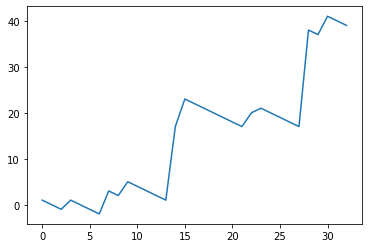

In [118]:
m_consecutive_loses = 0
m_consecutive_wins = 0

consecutive_loses = 0
consecutive_wins = 0


walk = [1]

for i, row in df_new.loc[df_new["pred"] == 1].iterrows():
    if row["classement"] != 1:
        consecutive_loses +=1
        m_consecutive_wins = max(m_consecutive_wins, consecutive_wins)
        consecutive_wins = 0
        
        walk.append(walk[-1] - 1)
    else:
        if not np.isnan(row["dernierRapportDirect_rapport"]):
            walk.append(walk[-1] + int(row["dernierRapportDirect_rapport"]))
            
        consecutive_wins += 1
        
        m_consecutive_loses = max(m_consecutive_loses, consecutive_loses)
        consecutive_loses = 0

print(m_consecutive_wins, m_consecutive_loses, walk[-1])
plt.plot(walk)

In [208]:
today = pd.read_csv("today.csv", index_col=0)
today_feat = today.loc[:][features_pred]
today_feat["dernierRapportReference_indicateurTendance"] = today_feat["dernierRapportReference_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0)
today_feat = today_feat.apply(pd.to_numeric, errors="coerce")
today_feat

,num,tpsLastRace,last_race_dist,fer,firstTimeFer,sex,age_x,dist,avisTrainer,lastPerf,...,gainsParticipant_gainsPlace,dernierRapportReference_indicateurTendance,gainsParticipant_gainsAnneeEnCours,gainsParticipant_gainsAnneePrecedente,dernierRapportReference_rapport,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple
0,1.0,72,2800,3,False,1,7,2650,3,0,...,2090000.0,1.0,0.0,0.0,52.0,7,0,0,0,0
1,2.0,8,2725,2,False,1,7,2650,2,6,...,3857000.0,1.0,789000.0,987000.0,25.0,12,0,1,2,25
2,3.0,14,2725,3,False,1,7,2650,2,2,...,2622500.0,0.0,1023500.0,628000.0,2.5,10,2,2,2,60
3,4.0,14,2725,2,False,1,7,2650,2,5,...,2604000.0,0.0,1443000.0,417000.0,8.9,15,4,0,1,33
4,5.0,29,2650,3,False,1,8,2650,2,8,...,3887000.0,-1.0,476000.0,907000.0,16.0,9,0,0,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,12.0,8,2875,3,False,1,6,2450,1,7,...,NaN,0.0,NaN,NaN,NaN,0,0,0,0,0
12,13.0,15,2825,0,False,1,6,2450,3,0,...,NaN,0.0,NaN,NaN,NaN,3,0,0,1,33
13,14.0,97,2725,0,False,1,6,2450,3,4,...,NaN,0.0,NaN,NaN,NaN,12,0,1,1,16
14,15.0,8,2875,0,False,1,6,2450,3,8,...,NaN,0.0,NaN,NaN,NaN,7,0,1,2,42


In [31]:
today.loc[today["numCoursePMU"] == "R10C3"]["dernierRapportDirect_rapport"]

0     29.5
1     61.1
2     67.3
3      6.3
4      3.8
5     68.7
6      7.7
7      6.5
8     41.1
9      5.0
10    31.3
11     8.0
Name: dernierRapportDirect_rapport, dtype: float64

In [151]:
list(today)

['num',
 'nom',
 'id',
 'date',
 'url',
 'tpsLastRace',
 'last_race_dist',
 'fer',
 'firstTimeFer',
 'sex',
 'age_x',
 'dist',
 'driver_x',
 'trainer',
 'avisTrainer',
 'music',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'numPmu',
 'age_y',
 'sexe',
 'race',
 'statut',
 'oeilleres',
 'proprietaire',
 'entraineur',
 'driver_y',
 'driverChange',
 'indicateurInedit',
 'musique',
 'nombreCourses',
 'nombreVictoires',
 'nombrePlaces',
 'nombrePlacesSecond',
 'nombrePlacesTroisieme',
 'nomPere',
 'nomMere',
 'jumentPleine',
 'engagement',
 'supplement',
 'handicapDistance',
 'poidsConditionMonteChange',
 'urlCasaque',
 'eleveur',
 'allure',
 'avisEntraineur',
 'robe_code',
 'robe_libelleCourt',
 'robe_libelleLong',
 'gainsParticipant_gainsCarriere',
 'gainsParticipant_gainsVictoires',
 'gainsParticipant_gainsPlace',
 'gainsParticipant_gainsAnneeEnCours',
 'gainsParticipant_gainsAnneePrecedente',
 'dernierRapportDirect_typePari',
 'dernierRappor

In [209]:
pred_today = gbm.predict(today_feat)

In [210]:
today["pred"] = pred_today
today['pred'] = today.groupby("id")["pred"].rank("dense",ascending=True).astype(int)
today['pred'] = today.groupby("id")["pred"].rank("first").astype(int)

In [34]:
today.loc[today["numCoursePMU"] == "R4C4"].sort_values(by="pred")[["num","numCoursePMU" ,"nom", "pred"]]

,num,numCoursePMU,nom,pred
4,5,R4C4,JEWEL D'AUCHY,1
2,3,R4C4,JAVA DU MONCEL,2
5,6,R4C4,JET MENCOURT,3
9,10,R4C4,JUSTIN BOLD,4
3,4,R4C4,JULIA QUESNOT,5
8,9,R4C4,JOY BLUE,6
6,7,R4C4,JAGGERA BOMB,7
0,1,R4C4,JALDO D'OCQUE,8
1,2,R4C4,JARVIS,9
7,8,R4C4,JINGLE GEDE,10


In [160]:
groupe_len = today[["num", "nom","pred","id","url"]].groupby("id").size()

In [211]:
winners = today[["numCoursePMU","num", "nom","dernierRapportReference_rapport","pred"]].loc[today["pred"]==1]
winners

,numCoursePMU,num,nom,dernierRapportReference_rapport,pred
2,R1C1,3,FOX DU RIB,2.5,1
12,R1C3,13,IGNACE GUENESERIE,15.0,1
7,R1C6,8,HAUT BRION CODIE,7.9,1
5,R1C7,6,FARSIGHT ABSOLUTE,9.1,1
1,R1C8,2,DOLLAR DU CAUX,16.0,1
12,R4C1,13,DIWI D'OCCAGNES,7.4,1
4,R4C2,5,HYTHO D'ALCI,14.0,1
7,R4C3,8,INEDIT DU GADE,8.0,1
3,R4C4,4,JULIA QUESNOT,2.5,1
10,R4C5,11,GINKGO DES GRANGES,9.5,1


In [22]:
winners2 = winners.dropna()
winners2

,numCoursePMU,num,nom,dernierRapportReference_rapport,pred
2,R1C1,3,FOX DU RIB,2.5,1
12,R1C3,13,IGNACE GUENESERIE,15.0,1
0,R1C6,1,HAUTAIN DE HOUELLE,19.0,1
5,R1C7,6,FARSIGHT ABSOLUTE,9.1,1
9,R1C8,10,ETOILE ROUGE,14.0,1
12,R4C1,13,DIWI D'OCCAGNES,7.4,1
4,R4C2,5,HYTHO D'ALCI,14.0,1
7,R4C3,8,INEDIT DU GADE,8.0,1
3,R4C4,4,JULIA QUESNOT,2.5,1
13,R4C5,14,GERONIMO STARDUST,8.6,1


In [30]:
def kelly(rapport, capital, p):
    return p-(1-p)/rapport

In [47]:
kelly(50,250,0.1) * 250

20.5

In [34]:
capital = 25
winners2["mises"] = winners2["dernierRapportReference_rapport"].apply(lambda x: kelly(x, capital, get_proba(x-5,x+5)) * capital)
winners2

<ipython-input-34-133932dede4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners2["mises"] = winners2["dernierRapportReference_rapport"].apply(lambda x: kelly(x, capital, get_proba(x-5,x+5)) * capital)


,numCoursePMU,num,nom,dernierRapportReference_rapport,pred,mises
2,R1C1,3,FOX DU RIB,2.5,1,6.682555
12,R1C3,13,IGNACE GUENESERIE,15.0,1,7.534351
0,R1C6,1,HAUTAIN DE HOUELLE,19.0,1,6.977276
5,R1C7,6,FARSIGHT ABSOLUTE,9.1,1,7.144606
9,R1C8,10,ETOILE ROUGE,14.0,1,6.187708
12,R4C1,13,DIWI D'OCCAGNES,7.4,1,8.016579
4,R4C2,5,HYTHO D'ALCI,14.0,1,6.187708
7,R4C3,8,INEDIT DU GADE,8.0,1,7.758526
3,R4C4,4,JULIA QUESNOT,2.5,1,6.682555
13,R4C5,14,GERONIMO STARDUST,8.6,1,7.234860


In [139]:
winners["mises"] * winners["dernierRapportDirect_rapport"]

11     28.188602
10     16.208354
0     150.000000
13     77.932422
10     20.670172
11    144.349776
6      31.152423
dtype: float64

In [35]:
winners2["mises"].sum()

77.49185597503941

In [44]:
rapport = 8
kelly(rapport,25,get_proba(rapport-5,rapport+5)) * 25

7.758526453869699